In [1]:
import numpy as np
import xgboost as xgb
import pandas as pd
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt

c:\Users\Administrator\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
from scipy.stats import skew, norm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

In [3]:
train = pd.read_csv("./data/House price prediction/train.csv")
test = pd.read_csv("./data/House price prediction/test.csv")

In [4]:
train.drop(['Id'], axis = 1, inplace = True)
test.drop(['Id'], axis = 1, inplace = True)

In [5]:
# Fix the skew of the data

train['SalePrice'] = np.log1p(train['SalePrice'])

c:\Users\Administrator\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

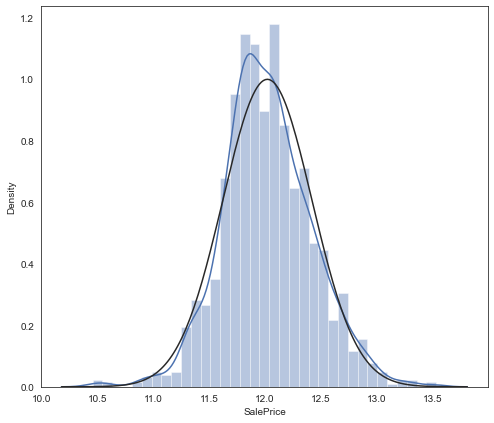

In [6]:
sns.set_style('white')
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize = (8, 7))
sns.distplot(train['SalePrice'], fit = norm, color='b')

In [7]:
(mu, sigma) = norm.fit(train['SalePrice'])
print(f" mu = {mu}; sigma = {sigma} ")

 mu = 12.024057394918406; sigma = 0.39931245219387496 


In [8]:
# Remove outliers (I've lost the point here)

# train.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index, inplace=True)
# train.drop(train[(train['GrLivArea']>4500) & (train['SalePrice']<300000)].index, inplace=True)
# train.reset_index(drop=True, inplace=True)

In [9]:
train_labels = train['SalePrice'].reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)
test_features = test


# Concat all the features (test + train)
all_features = pd.concat([train_features, test_features]).reset_index(drop=True)
all_features.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [10]:
def missing(df):
 data = pd.DataFrame(df)
 df_cols = list(pd.DataFrame(data))

 dict_x = {}
 for i in range(0, len(df_cols)):
  dict_x.update({df_cols[i]: round(data[df_cols[i]].isnull().mean()*100, 2)})
 
 return dict_x

In [11]:
missing_ratio = missing(all_features)
df_miss = sorted(missing_ratio.items(), key = lambda x: x[1], reverse = True)
df_miss[0:10]

[('PoolQC', 99.66),
 ('MiscFeature', 96.4),
 ('Alley', 93.22),
 ('Fence', 80.44),
 ('FireplaceQu', 48.65),
 ('LotFrontage', 16.65),
 ('GarageYrBlt', 5.45),
 ('GarageFinish', 5.45),
 ('GarageQual', 5.45),
 ('GarageCond', 5.45)]

In [12]:
all_features["MSSubClass"] = all_features["MSSubClass"].astype(str)
all_features['YrSold'] = all_features['YrSold'].astype(str)
all_features['MoSold'] = all_features['MoSold'].astype(str)

In [13]:
def handle_missing(features):
 features['Functional'] = features['Functional'].fillna("Typ")
 features['Electrical'] = features['Electrical'].fillna("SBrkr")
 features['KitchenQual'] = features['KitchenQual'].fillna("TA")

 features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
 features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
 features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

 features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

 #Check MSZoning

 features['PoolQC'] = features['PoolQC'].fillna("None")
 for col in ("GarageYrBlt", "GarageArea", "GarageCars"):
  features[col] = features[col].fillna(0)
 for col in ("GarageType", "GarageFinish", "GarageQual", "GarageCond"):
  features[col] = features[col].fillna("None")
 for col in ("BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"):
  features[col] = features[col].fillna("None")

 features['LotFrontage'] = features.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

 objects = []

 for i in features.columns:
  if features[i].dtype == object:
   objects.append(i)
 
 features.update(features[objects].fillna("None"))

 num_dtypes = ["float64", "int64", "float32", 'int32', 'float16', 'int16']

 numerics = []
 for i in features.columns:
  if features[i].dtype in num_dtypes:
   numerics.append(i)
 
 features.update(features[numerics].fillna(0))

 return features

In [14]:
all_features = handle_missing(all_features)

In [15]:
missing_ratio = missing(all_features)
df_miss = sorted(missing_ratio.items(), key = lambda x: x[1], reverse = True)
df_miss[0:10]

[('MSSubClass', 0.0),
 ('MSZoning', 0.0),
 ('LotFrontage', 0.0),
 ('LotArea', 0.0),
 ('Street', 0.0),
 ('Alley', 0.0),
 ('LotShape', 0.0),
 ('LandContour', 0.0),
 ('Utilities', 0.0),
 ('LotConfig', 0.0)]

In [16]:
# Fix the skew
numeric_dtypes = ["int16", "float16", "int32", "float32", "int64", "float64"]
numerics = []

for i in all_features.columns:
 if all_features[i].dtype in numeric_dtypes:
  numerics.append(i)

print(numerics)

['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']


In [17]:
skew_features = all_features[numerics].apply(lambda x: skew(x)).sort_values(ascending = False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index
print(f"There are {high_skew.shape[0]} skewed features")
skewnewss = pd.DataFrame({"Skew": high_skew})
skew_features.head(5)

There are 25 skewed features


MiscVal         21.947195
PoolArea        16.898328
LotArea         12.822431
LowQualFinSF    12.088761
3SsnPorch       11.376065
dtype: float64

In [18]:
# Fix the skew with the help of box cox
from scipy.stats import boxcox_normmax
from scipy.special import boxcox1p

print(skew_index)


for i in skew_index:
 all_features[i] = boxcox1p(all_features[i], boxcox_normmax(all_features[i] + 1))

Index(['MiscVal', 'PoolArea', 'LotArea', 'LowQualFinSF', '3SsnPorch',
       'KitchenAbvGr', 'BsmtFinSF2', 'EnclosedPorch', 'ScreenPorch',
       'BsmtHalfBath', 'MasVnrArea', 'OpenPorchSF', 'WoodDeckSF',
       'LotFrontage', '1stFlrSF', 'BsmtFinSF1', 'GrLivArea', 'TotalBsmtSF',
       'BsmtUnfSF', '2ndFlrSF', 'TotRmsAbvGrd', 'Fireplaces', 'HalfBath',
       'BsmtFullBath', 'OverallCond'],
      dtype='object')


c:\Users\Administrator\anaconda3\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\Users\Administrator\anaconda3\lib\site-packages\scipy\stats\stats.py:4053: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


In [19]:
skew_features = all_features[numerics].apply(lambda x: skew(x)).sort_values(ascending = False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index
print(f"There are {high_skew.shape[0]} skewed features")
skewnewss = pd.DataFrame({"Skew": high_skew})
skew_features.head(5)

There are 16 skewed features


PoolArea        14.985994
3SsnPorch        8.865144
LowQualFinSF     8.495602
MiscVal          5.239894
BsmtHalfBath     3.780960
dtype: float64

In [20]:
print((all_features['WoodDeckSF'] == 0) * 1)

0       1
1       0
2       1
3       1
4       0
       ..
2914    1
2915    1
2916    0
2917    0
2918    0
Name: WoodDeckSF, Length: 2919, dtype: int32


In [21]:
# Optimize features

all_features['BsmtFinType1_Unf'] = (all_features['BsmtFinType1'] == 'Unf') * 1
all_features['HasWoodDeck'] = (all_features['WoodDeckSF'] == 1) * 1
all_features['HasOpenPorch'] = (all_features['OpenPorchSF'] == 1) * 1
all_features['HasEnclosedPorch'] = (all_features['EnclosedPorch'] == 1) * 1
all_features['Has3SsnPorch'] = (all_features['3SsnPorch'] == 1) * 1
all_features['HasScreenPorch'] = (all_features['ScreenPorch'] == 1) * 1
all_features["YearsSinceRemodal"] = all_features['YrSold'].astype(int) - all_features['YearRemodAdd'].astype(int)
all_features['Total_Home_Quality'] = all_features['OverallQual'].astype(int) + all_features['OverallCond'].astype(int)
all_features = all_features.drop(['Utilities', 'Street', 'PoolQC'], axis=1)
all_features['TotalSF'] = all_features['TotalBsmtSF'] + all_features['1stFlrSF'] + all_features['2ndFlrSF']
all_features['YrBltAndRemod'] = all_features['YearBuilt'] + all_features['YearRemodAdd']
all_features['Total_sqr_footage'] = all_features['BsmtFinSF1'] + all_features['BsmtFinSF2'] + all_features['1stFlrSF'] + all_features['2ndFlrSF']
all_features['Total_Bathrooms'] = (all_features['FullBath'] + all_features['HalfBath'] * 0.5) + (all_features['BsmtFullBath'] + all_features['BsmtHalfBath'] * 0.5)
all_features['Total_porch_sf'] = all_features['3SsnPorch'] + all_features['ScreenPorch'] + all_features['EnclosedPorch'] + all_features['WoodDeckSF'] + all_features['OpenPorchSF']
all_features['TotalBsmtSF'] = all_features['TotalBsmtSF'].apply(lambda x: np.exp(6.0) if x <= 0.0 else x)
all_features['2ndFlrSF'] = all_features['2ndFlrSF'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
all_features['GarageArea'] = all_features['GarageArea'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
all_features['GarageCars'] = all_features['GarageCars'].apply(lambda x: 0 if x <= 0.0 else x)
all_features['LotFrontage'] = all_features['LotFrontage'].apply(lambda x: np.exp(4.2) if x <= 0.0 else x)
all_features['MasVnrArea'] = all_features['MasVnrArea'].apply(lambda x: np.exp(4) if x <= 0.0 else x)
all_features['BsmtFinSF1'] = all_features['BsmtFinSF1'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
all_features['haspool'] = all_features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_features['has2ndfloor'] = all_features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasgarage'] = all_features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasbsmt'] = all_features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasfireplace'] = all_features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [22]:
def logs(res, ls):
 m = res.shape[1]
 for l in ls:
  res = res.assign(newcol = pd.Series(np.log(1.01 + res[l])).values)
  res.columns.values[m] = l + "_log"
  m += 1
 return res

In [23]:
log_features = ['LotFrontage', 'LotArea', 'TotalBsmtSF', "TotRmsAbvGrd", "Fireplaces", "EnclosedPorch", "3SsnPorch", "OpenPorchSF", "KitchenAbvGr", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "TotalSF", "BsmtHalfBath", "BsmtFullBath", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "LowQualFinSF", "GrLivArea", "MiscVal", "WoodDeckSF", "GarageArea", "BedroomAbvGr", "PoolArea", "ScreenPorch", "YearRemodAdd", "GarageCars"]

all_features = logs(all_features, log_features)

In [24]:
# Encode all the values to the numerical type

all_features = pd.get_dummies(all_features).reset_index(drop=True)
all_features.shape

(2919, 371)

In [25]:
# Remove all the duplicate column names
all_features = all_features.loc[:, ~all_features.columns.duplicated()]

In [26]:
X = all_features.iloc[:len(train_labels), :]
X_test = all_features.iloc[len(train_labels):, :]

In [27]:
kf = KFold(n_splits=12, random_state=42, shuffle=True)

def rmsle(y, y_pred):
 return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
 rmse = np.sqrt(-cross_val_score(model, X, train_labels, scoring='neg_mean_squared_error', cv=kf))
 return (rmse)

In [28]:
# Random Forest model

rf = RandomForestRegressor(n_estimators=1200, max_depth = 15, min_samples_leaf=5, min_samples_split=5, max_features=None, oob_score=True, random_state=42)

rf_model = rf.fit(X, train_labels)

In [29]:
rf_model.predict(X)

array([12.2406136 , 12.06693936, 12.29491398, ..., 12.43992792,
       11.82903032, 11.917605  ])

In [30]:
rmsle(train_labels, rf_model.predict(X))

0.09029136892305453